In this notebook we start the modelling of the data with an XGBoost model and obtain the submission csv file.

# Modelling

In [74]:
import gc
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from xgboost import plot_importance
from xgboost import XGBRegressor

pd.options.display.max_rows = None

Read the data from 1_data_prep.

In [75]:
ts = time.time()
#data = pd.read_pickle('/kaggle/input/predict-future-sales-marcus-week-4-part-i/data.pkl')
data = pd.read_pickle('data.pkl')
time.time() - ts

3.1246166229248047

Read the test file we need for submission

In [76]:
test = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/test.csv')

We use month 33 (October 2015) as validation for training. Month 34 (November 2015) is our test period.

Here we implicitly assume that the trends observed in October persist in November. An alternative would be to use November 2014 as our validation data, and only use previous data for training.

In [77]:
X = data.drop('item_cnt_month_shop_item', axis = 1) # We drop the target.

X_train = X[X.date_block_num < 33]
y_train = data[data.date_block_num < 33]['item_cnt_month_shop_item']

X_val = X[X.date_block_num == 33]
y_val = data[data.date_block_num == 33]['item_cnt_month_shop_item']

X_test = X[X.date_block_num == 34]
X_test = X_test.reset_index()
del X_test['index']

In [78]:
del data
del X
gc.collect();

We drop date_block_num since it is only used to split the data into train and validation sets.

In [79]:
#X_train = X_train.drop('date_block_num', axis = 1)
#X_val = X_val.drop('date_block_num', axis = 1)
#X_test = X_test.drop('date_block_num', axis = 1)

**Note:** We try keeping it and see if our score is improved.

After training our model we can evaluate the feature importances and decide which features we want to keep.

In [80]:
#features_to_keep = pickle.load(open('features_to_keep.save', 'rb'))
#print('Number of features before feature selection:', len(X_train.columns))
#X_train = X_train[features_to_keep]
#X_val = X_val[features_to_keep]
#X_test = X_test[features_to_keep]
#print('Number of features after feature selection:', len(X_train.columns))

We begin by training the default XGBRegressor(), we only set max_depth = 7.

In [81]:
ts = time.time()

model = XGBRegressor(
    seed = 1,
    #njobs = -1,
    n_estimators = 1000,
    #max_depth = 7)
    #max_depth = 8)
    #max_depth = 9)
    #max_depth = 10)
    max_depth = 6)

#GH
#model = XGBRegressor(
#    seed = 1,
#    #njobs = -1,
#    n_estimators = 1000,
#    #max_depth = 10,
#    max_depth = 7,
#    min_child_weight = 0.5, 
#    colsample_bytree = 0.8, 
#    subsample = 0.8, 
#    eta = 0.1,
#    )

#DL
#model = XGBRegressor(
#    seed = 1
#    n_estimators = 1000,
#    max_depth = 8,    
#    min_child_weight = 300, 
#    colsample_bytree = 0.8, 
#    subsample = 0.8, 
#    eta = 0.3,    
#    )


model.fit(
    X_train, 
    y_train, 
    eval_metric = "rmse", 
    eval_set = [(X_train, y_train), (X_val, y_val)], 
    verbose = True, 
    early_stopping_rounds = 20)

time.time() - ts

[0]	validation_0-rmse:1.08486	validation_1-rmse:1.05389
[1]	validation_0-rmse:1.00640	validation_1-rmse:0.99653
[2]	validation_0-rmse:0.96053	validation_1-rmse:0.96572
[3]	validation_0-rmse:0.93117	validation_1-rmse:0.95063
[4]	validation_0-rmse:0.91545	validation_1-rmse:0.94273
[5]	validation_0-rmse:0.90168	validation_1-rmse:0.93703
[6]	validation_0-rmse:0.89321	validation_1-rmse:0.93278
[7]	validation_0-rmse:0.88857	validation_1-rmse:0.93181
[8]	validation_0-rmse:0.88454	validation_1-rmse:0.92816
[9]	validation_0-rmse:0.87858	validation_1-rmse:0.92493
[10]	validation_0-rmse:0.87637	validation_1-rmse:0.92343
[11]	validation_0-rmse:0.87309	validation_1-rmse:0.92425
[12]	validation_0-rmse:0.87133	validation_1-rmse:0.92351
[13]	validation_0-rmse:0.86915	validation_1-rmse:0.92309
[14]	validation_0-rmse:0.86768	validation_1-rmse:0.92280
[15]	validation_0-rmse:0.86641	validation_1-rmse:0.92208
[16]	validation_0-rmse:0.86454	validation_1-rmse:0.92185
[17]	validation_0-rmse:0.86282	validation

1656.620970249176

In [82]:
filename = 'models/xgb_model_#10.save'

In [83]:
pickle.dump(model, open(filename, 'wb'))

In [84]:
#model = pickle.load(open(filename, 'rb'))

In [85]:
print('Best validation score:', model.best_score)
print('Best iteration:', model.best_iteration)

Best validation score: 0.908155
Best iteration: 35


In [89]:
y_test = model.predict(X_test).clip(0, 20)

my_submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
my_submission.to_csv('xgb_submission.csv', index=False)
my_submission.head()

,ID,item_cnt_month
0,0,0.536018
1,1,0.221058
2,2,1.284701
3,3,0.554701
4,4,2.483511


**Note:** How is the .fit() method really performed? Does it make any sense to "retrain" the model on X_train + X_val, y_train + y_val, which we can do in many scikit-learn models? I started looking at the xgb_model parameter but did not reach any conclusions.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

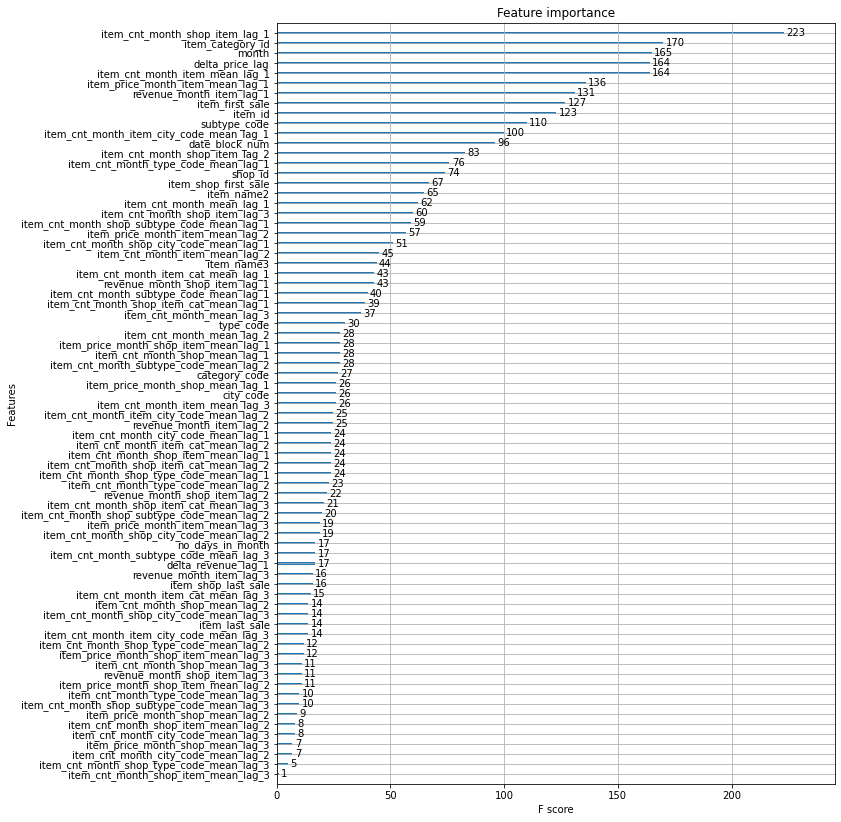

In [90]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    return plot_importance(booster = booster, ax = ax)

plot_features(model, (10, 14))

Some features get 0 importance - we remove them for our next training.

In [91]:
print('Number of features before feature selection:', len(model.feature_importances_))
features_to_keep = [feature for feature in list(X_train.columns) if feature in model.get_booster().get_score()]
print('Number of features after feature selection:', len(features_to_keep))
print('Features excluded:', set(list(X_train.columns)) - set(features_to_keep))

Number of features before feature selection: 78
Number of features after feature selection: 75
Features excluded: {'revenue_month_shop_lag_3', 'revenue_month_shop_lag_1', 'revenue_month_shop_lag_2'}


In [16]:
pickle.dump(features_to_keep, open('features_to_keep_xgb.save', 'wb'))

# Evaluation of models

1. Score to beat: 1.16777 - previous_value_benchmark

2. Score: 1.02076 (better), val. score: 0.972477 - Default XGBRegressor() without train_monthly_per_shop and train_monthly_per_item_id.

3. Score: 0.99807 (better), train. score: 0.91097, val. score: 0.95964 - Default XGBRegressor() with train_monthly_per_shop and train_monthly_per_item_id and lags.

4. Score: 0.99353 (better), train. score: 0.88499  ,val. score: 0.94914 - XGBRegressor(max_depth = 7) with revenue (per shop & item, shop and item) and lags, removed date_block_num before fitting 

**Note:** It is apparent here that the model is overfitting.

5. Score: -, train. score: 0.88163, val. score: 0.94792 - item_price added as feature (only with sum).

6. Score: -, train. score: 0.86416, val. score: 0.94881 - item_price added as feature (with sum and mean)

**Note:** The mean is more important useful for the model than sum. We can probably skip sum completely.

7. Score: 0.95677 (better), train. score: 0.80878, val. score: 0.897584, Coursera public/private score: 8/10 (0.958179) - Significant FE with 74 features in total (xgb model #1)

8. Score: 0.93974 (better), train. score: 0.79562, val. score: 0.894429, Coursera public/private score: 8/10 (0.950514) - Exclude val. period from trend related features, use .fillna(0) for item_cnt and revenue related features and use .fillna(-999) for price related features (xgb model #2)

9. Score: 0.93950 (better), train. score: 0.79324, val. score: 0.89930, Coursera public/private score: 10/10 (0.941447) - Set train.item_cnt_day < 1000, shops: clean, add binned category, bin city_code, categories: bin type_code, items: add item_name2 and item_name3, no feature selection (xgb_model #3).

**Note:** city_code became much more important.

10. The same results with feature selection - 3 features dropped (xgb_model #4).

11. **(HPO)** Score: 0.93035 (better), train. score: 0.73687, val. score: 0.88529, Coursera public/private score: 10/10 (0.937713) -  (xgb_model #5) - HPO following Gordon Henderson; despite the much better train. score, val score. wasn't improved that much, and the LB score was only marginally improved.

**Note:** max_depth = 10 here, which might render the feature selection performed non-viable.

12.	Score: 0.94305 (worse), train. score: 0.76337, val. score: 0.89337 - Add date_block_num (it's fairly important), no feature selection, no HPO (just max_depth = 7) (xgb_model #6).

**Note:** The gap between train and val score is fairly big now, regularization is needed. We keep the date_block_num feature.

13. Score: 0.94094 (worse), train. score: 0.79259, val. score: 0.89710 - No feature selection, no HPO (just max_depth = 8) (xgb_model #7).

14. Score: 0.94377 (worse), train. score: 0.78223, val. score: 0.89238 - No feature selection, no HPO (just max_depth = 9) (xgb_model #8). 

15. Score: 0.94060 (worse), train. score: 0.77611, val. score: 0.89850 - No feature selection, no HPO (just max_depth = 10) (xgb_model #9).

16. Score: 0.94364 (worse), train. score: 0.83937, val. score: 0.90816 - No feature selection, no HPO (just max_depth = 6) (xgb_model #10).

**Note:** When we we just adjust max_depth, max_depth = 10 gets the best result.